In [1]:
# import sys
# !{sys.executable} -m pip install ing_theme_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
# import qbstyles
# from ing_theme_matplotlib import mpl_style
import glacierml as gl
from tqdm import tqdm

# Step 1: Organize the data

## A. Load and organize the Glathida dataset

In [2]:
# raw_dataset = pd.read_csv('/data/fast0/datasets/glathida-3.1.0/data/T.csv')
T = pd.read_csv('/home/sa42/data/glac/T_models/T.csv')
T.rename(columns = {
    'LAT':'T_LAT_CENT',
    'LON':'T_LON_CENT',
    'AREA':'T_AREA',
    'MEAN_SLOPE':'T_MEAN_SLOPE',
    'MEAN_THICKNESS':'T_MEAN_THICKNESS',
    'MAXIMUM_THICKNESS':'T_MAXIMUM_THICKNESS' 
},inplace=True)
TT = pd.read_csv('/home/sa42/data/glac/T_models/TT.csv')
TT.rename(columns = {
    'AREA':'TT_AREA',
    'MEAN_SLOPE':'TT_MEAN_SLOPE',
    'MEAN_THICKNESS':'TT_MEAN_THICKNESS',
    'MAXIMUM_THICKNESS':'TT_MAXIMUM_THICKNESS',   
},inplace=True)
TTT = pd.read_csv('/home/sa42/data/glac/T_models/TTT.csv')
TTT.rename(columns = {
    'ELEVATION':'POINT_ELEVATION',
    'THICKNESS':'POINT_THICKNESS',
},inplace=True)
df1 = pd.merge(T,TT, how = 'inner', on='GlaThiDa_ID')
glathida = pd.merge(df1,TTT, how = 'inner', on='GlaThiDa_ID')
glathida = glathida[[
#     'GlaThiDa_ID',
#     'GLACIER_DB',
#     'GLACIER_ID',
    'T_LAT_CENT',
    'T_LON_CENT',
    'T_AREA',
    'T_MEAN_SLOPE',
    'T_MEAN_THICKNESS',
    'T_MAXIMUM_THICKNESS',
    'LOWER_BOUND',
    'UPPER_BOUND',
    'TT_AREA',
    'TT_MEAN_SLOPE',
    'TT_MEAN_THICKNESS',
    'TT_MAXIMUM_THICKNESS',
    'POINT_LAT',
    'POINT_LON',
    'POINT_ELEVATION',
    'POINT_THICKNESS',   
]]
glathida = glathida.dropna()

/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (2,4,5,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### separate out features - what will be trained to predict desired attribute

In [3]:
train_dataset = glathida.sample(frac=0.8, random_state=0)
test_dataset = glathida.drop(train_dataset.index)

train_features = train_dataset.copy()
test_features = test_dataset.copy()

#define label - attribute training to be picked
train_labels = train_features.pop("POINT_THICKNESS")
test_labels = test_features.pop("POINT_THICKNESS")

train_features.describe().transpose()[['mean', 'std']]

,mean,std
T_LAT_CENT,45.248784,7.555996
T_LON_CENT,29.965947,36.370518
T_AREA,1.022082,1.387955
T_MEAN_SLOPE,21.421017,5.425289
T_MEAN_THICKNESS,22.792425,16.785250
T_MAXIMUM_THICKNESS,74.305944,45.827023
LOWER_BOUND,2956.907234,678.711591
UPPER_BOUND,2999.129260,693.300833
TT_AREA,0.423253,0.636670
TT_MEAN_SLOPE,23.084023,9.011630


# Step 2: Setup the Model

### Establish normalization layers

In [4]:
normalizer = {}
variable_list = list(train_features)
for variable_name in tqdm(variable_list):

    normalizer[variable_name] = gl.preprocessing.Normalization(input_shape=[1,], axis=None)
    normalizer[variable_name].adapt(np.array(train_features[variable_name]))
    
    
normalizer['ALL'] = gl.preprocessing.Normalization(axis=-1)
normalizer['ALL'].adapt(np.array(train_features))

  0%|          | 0/15 [00:00<?, ?it/s]2022-03-18 21:23:24.129986: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-18 21:23:24.130024: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sermeq.ess.washington.edu): /proc/driver/nvidia/version does not exist
2022-03-18 21:23:24.130771: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
100%|██████████| 15/15 [00:18<00:00,  1.24s/it]


### Single variable linear regression functions

In [5]:
test_results = {}
linear_model = {}
linear_history = {}
linear_results = {}

# Linear regression

In [9]:
%%time
for variable_name in tqdm(variable_list):

    linear_model[variable_name] = gl.build_linear_model(normalizer[variable_name])
    linear_history[variable_name] = linear_model[variable_name].fit(
                                        train_features[variable_name], train_labels,        
                                        epochs=1,
                                        verbose=0,
                                        validation_split = 0.2)
    
    
    linear_results[variable_name] = linear_model[variable_name].evaluate(
                                        test_features[variable_name],
                                        test_labels, verbose=0)

linear_results

100%|██████████| 15/15 [00:33<00:00,  2.21s/it]

CPU times: user 41.1 s, sys: 2.91 s, total: 44.1 s
Wall time: 33.1 s


{'T_LAT_CENT': 23.552549362182617,
 'T_LON_CENT': 19.413753509521484,
 'T_AREA': 15.523979187011719,
 'T_MEAN_SLOPE': 21.77544593811035,
 'T_MEAN_THICKNESS': 17.3526668548584,
 'T_MAXIMUM_THICKNESS': 15.397465705871582,
 'LOWER_BOUND': 20.760108947753906,
 'UPPER_BOUND': 20.772375106811523,
 'TT_AREA': 23.56038475036621,
 'TT_MEAN_SLOPE': 22.36348533630371,
 'TT_MEAN_THICKNESS': 20.541250228881836,
 'TT_MAXIMUM_THICKNESS': 19.604236602783203,
 'POINT_LAT': 23.561792373657227,
 'POINT_LON': 19.420686721801758,
 'POINT_ELEVATION': 20.34522247314453}

In [10]:
for variable_name in variable_list:    
    df = pd.DataFrame(linear_history[variable_name].history)
    dfs = df.loc[[df.last_valid_index()]]
    dfs.insert(0, 'Variable', [variable_name])
    
    print(dfs)
    print('')


     Variable       loss   val_loss
0  T_LAT_CENT  24.118351  23.655264

     Variable       loss   val_loss
0  T_LON_CENT  20.202127  19.168205

  Variable       loss   val_loss
0   T_AREA  16.571312  15.478696

       Variable       loss   val_loss
0  T_MEAN_SLOPE  22.345798  21.830477

           Variable       loss   val_loss
0  T_MEAN_THICKNESS  18.315872  17.541464

              Variable       loss   val_loss
0  T_MAXIMUM_THICKNESS  16.499632  15.459744

      Variable       loss   val_loss
0  LOWER_BOUND  21.473623  20.641802

      Variable       loss   val_loss
0  UPPER_BOUND  21.500906  20.663233

  Variable       loss   val_loss
0  TT_AREA  24.097218  23.654013

        Variable       loss   val_loss
0  TT_MEAN_SLOPE  22.998751  22.445646

            Variable       loss  val_loss
0  TT_MEAN_THICKNESS  21.347683  20.71979

               Variable       loss   val_loss
0  TT_MAXIMUM_THICKNESS  20.402819  19.744394

    Variable       loss  val_loss
0  POINT_LAT  24.108383  2

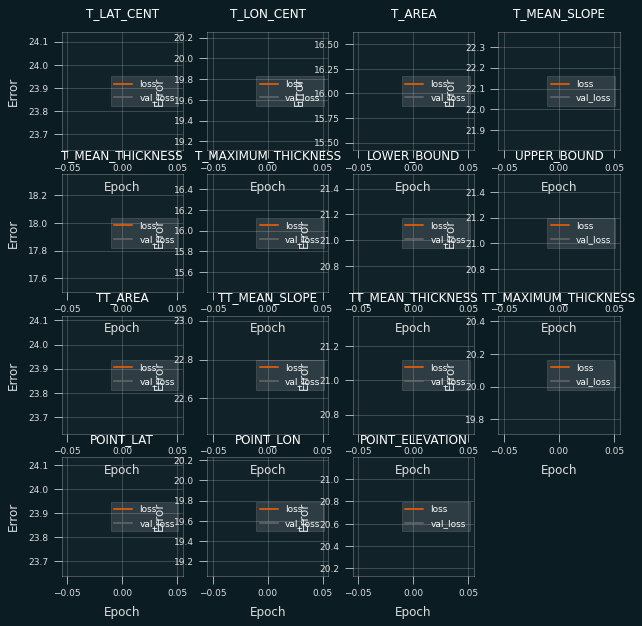

In [28]:
fig,ax=plt.subplots(2,6,figsize=(10,10))
for i, variable_name in enumerate(variable_list):
#     mpl_style("dark")
    ax = plt.subplot(4,4,i+1)
    plt.subplot(4,4,i+1)
    gl.plot_loss(linear_history[variable_name])
    ax.set_title(variable_name)
#     plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_loss.eps")

# Linear regression with multiple inputs

In [13]:
linear_model = gl.build_linear_model(normalizer['ALL'])

history_full = linear_model.fit(
train_features, train_labels,        
   epochs=1,
   verbose=0,
   validation_split = 0.2)

test_results['MULTI'] = linear_model.evaluate(
    test_features,
    test_labels, verbose=0)

test_results

{'MULTI': 14.214945793151855}

In [14]:
df = pd.DataFrame(history_full.history)
dfs = df.loc[[df.last_valid_index()]]
dfs.insert(0, 'Variable', 'Multi-Variable')
    
print(dfs)



         Variable       loss   val_loss
0  Multi-Variable  15.352184  14.140845


<function glacierml.plot_loss(history)>

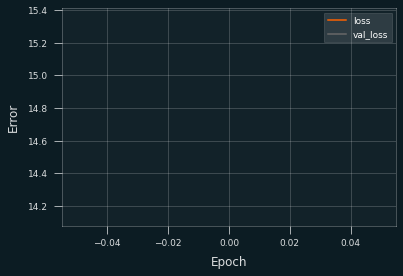

In [16]:
gl.plot_loss(history_full)
# plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_full_loss.eps")

# DNN regression

## Define regression functions

In [17]:
test_results = {}
dnn_model = {}
dnn_history = {}
dnn_results = {}

In [19]:
for variable_name in tqdm(variable_list):

    dnn_model[variable_name] = gl.build_dnn_model(normalizer[variable_name])
    dnn_history[variable_name] = dnn_model[variable_name].fit(
                                        train_features[variable_name], train_labels,        
                                        epochs=1,
                                        verbose=0,
                                        validation_split = 0.2)
    dnn_results[variable_name] = dnn_model[variable_name].evaluate(
                                        test_features[variable_name],
                                        test_labels, verbose=0)

dnn_results

100%|██████████| 15/15 [01:01<00:00,  4.09s/it]


{'T_LAT_CENT': 19.500703811645508,
 'T_LON_CENT': 18.572643280029297,
 'T_AREA': 15.14764404296875,
 'T_MEAN_SLOPE': 20.755512237548828,
 'T_MEAN_THICKNESS': 17.108882904052734,
 'T_MAXIMUM_THICKNESS': 14.960383415222168,
 'LOWER_BOUND': 19.559268951416016,
 'UPPER_BOUND': 19.216501235961914,
 'TT_AREA': 21.482887268066406,
 'TT_MEAN_SLOPE': 21.400257110595703,
 'TT_MEAN_THICKNESS': 19.974254608154297,
 'TT_MAXIMUM_THICKNESS': 19.18962287902832,
 'POINT_LAT': 19.523229598999023,
 'POINT_LON': 18.560495376586914,
 'POINT_ELEVATION': 18.734312057495117}

In [20]:
for variable_name in variable_list:    
    df = pd.DataFrame(dnn_history[variable_name].history)
    dfs = df.loc[[df.last_valid_index()]]
    dfs.insert(0, 'Variable', [variable_name])
    
    print(dfs)
    print('')


     Variable       loss   val_loss
0  T_LAT_CENT  20.189005  19.437382

     Variable       loss   val_loss
0  T_LON_CENT  18.765148  18.176344

  Variable      loss   val_loss
0   T_AREA  15.38876  15.039858

       Variable       loss   val_loss
0  T_MEAN_SLOPE  20.568226  20.875854

           Variable       loss  val_loss
0  T_MEAN_THICKNESS  17.544277  17.26078

              Variable       loss   val_loss
0  T_MAXIMUM_THICKNESS  15.162047  14.937061

      Variable       loss   val_loss
0  LOWER_BOUND  20.084738  19.235769

      Variable       loss  val_loss
0  UPPER_BOUND  19.981375  18.93833

  Variable       loss   val_loss
0  TT_AREA  22.158758  21.516497

        Variable       loss   val_loss
0  TT_MEAN_SLOPE  21.355736  21.409584

            Variable       loss   val_loss
0  TT_MEAN_THICKNESS  20.219351  20.120033

               Variable       loss   val_loss
0  TT_MAXIMUM_THICKNESS  19.322813  19.320105

    Variable       loss   val_loss
0  POINT_LAT  20.560163  19.4

In [21]:
# fig,ax=plt.subplots(4,4,figsize=(10,10))
# for i, variable_name in enumerate(variable_list):
#     plt.subplot(4,4,i+1)
#     xmax = np.max(train_features[variable_name])
#     xmin = np.min(train_features[variable_name])
#     x = tf.linspace(xmin, xmax, 101)
#     y = dnn_model[variable_name].predict(x)
#     plot_single_model_variable(x,y,variable_name)

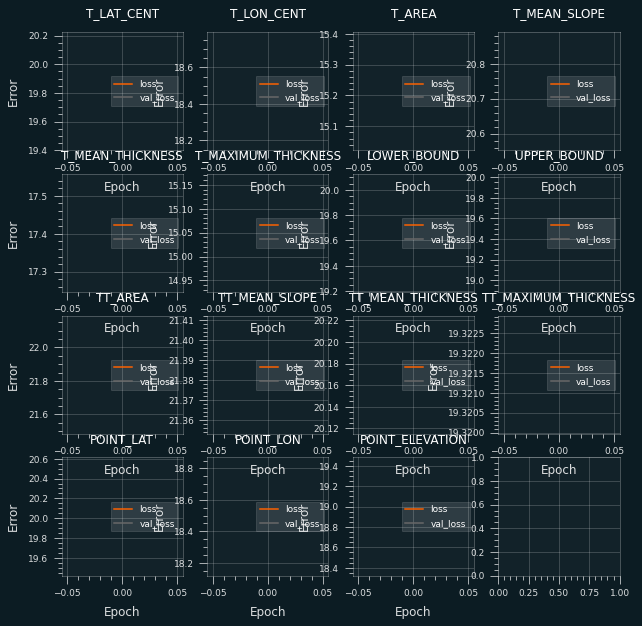

In [22]:
fig,ax=plt.subplots(4,4,figsize=(10,10))
for i, variable_name in enumerate(variable_list):
    ax = plt.subplot(4,4,i+1)
    gl.plot_loss(dnn_history[variable_name])
    ax.set_title(variable_name)
#     plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_dnn_loss.eps")

# Full model

In [23]:
dnn_full_model = gl.build_dnn_model(normalizer['ALL'])

In [24]:
%%time
dnn_history_full = dnn_full_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=1)

CPU times: user 32.4 s, sys: 7.05 s, total: 39.5 s
Wall time: 3.69 s


In [25]:
df = pd.DataFrame(dnn_history_full.history)
dfs = df.loc[[df.last_valid_index()]]
dfs.insert(0, 'Variable', 'Multi-Variable')
    
print(dfs)


         Variable       loss  val_loss
0  Multi-Variable  12.856212  12.57299


<function glacierml.plot_loss(history)>

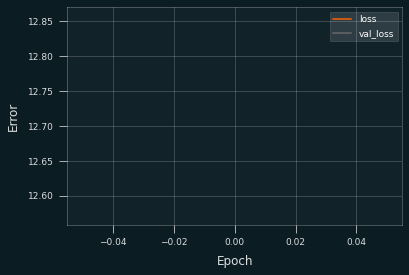

In [26]:
gl.plot_loss(dnn_history_full)
# plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_dnn_full_loss.png")

(0.0, 200.0)

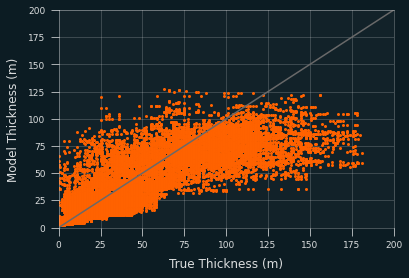

In [27]:
y = dnn_full_model.predict(test_features)
plt.plot(test_labels,y,'.')
plt.plot((0,200),(0,200),'-')
plt.xlabel('True Thickness (m)')
plt.ylabel('Model Thickness (m)')
plt.xlim((0,200))
plt.ylim((0,200))
# plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_res.EPS")